# ADA project: Milestone 2
### Team: YiYiSoDa - Yinghui Jiang, Yichen Wang, Sophia Ly, David Chaves

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
For project milestone 2 an agreement on the project proposal with its initial analysis was done. 
The goal of this project is to analyse the gender gap in movies. In order to do so the goal is to answer following questions: <br>
<li>How can the gender gap in the movie industry be grasped?
<li>Is there a difference of gender gap between genres?
<li>What is the gender gap across the world and how did it evolve over time?
<li>How will the gender gap evolve in the future and how long will it take for it to be closed?
<li>Is there a certain toppic that correlates with one gender?
<li>Is there a correlation with off screen inequality and on screen inequality?

In [58]:
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import tarfile
import re
import gzip
import spacy
import warnings
import math
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from PIL import Image
warnings.filterwarnings('ignore')

data_folder = './data/MovieSummaries/'
corenlp_folder = './data/corenlp_plot_summaries/'

## Task 1: Explore the dataset

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Each dataset is first loaded and then the number of NaN values were calculated. There are multiple ways on how to handle NaN such as discarding row, replacing with mean/ median. Since the best way of handling NaN values depend on which question should be answered, isn't treated yet.
Wherever there are tuples containing multiple values, rows are added to the dataframe so that each row had only one value.

### 1.1 movie.metadata.tsv.gz


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


##### Loading data

In [583]:
movies = data_folder + 'movie.metadata.tsv'
movies_cols = ['wiki_movie_id', 'freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'languages', 'countries','genres']

movies = pd.read_csv(movies, sep='\t', names=movies_cols, parse_dates=["release_date"], date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
movies.head()

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,movie_runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


##### Calculating NaN

In [584]:
# Calculate number of NaN
def NaN_percentage(df):
    '''
    Returns a df with columnname and their respective number of NaN and what percentage this corresponds to.
    Args:
        df = movies, characters
    '''
    
    n_NaN = []
    perc_NaN = []
    length = len(df)

    for column in df:
        i_nan = df[column].isna().sum()
        perc_nan = i_nan/ length
        n_NaN.append(i_nan)
        perc_NaN.append(perc_nan)

    # Create df with results
    index_df = df.columns.to_list()
    df_NaN = pd.DataFrame({'number of NaN':n_NaN, 'percentage of NaN':perc_NaN}, index= index_df )
    return df_NaN

In [585]:
movies_NaN = NaN_percentage(movies)
movies_NaN

,number of NaN,percentage of NaN
wiki_movie_id,0,0.000000
freebase_movie_id,0,0.000000
movie_name,0,0.000000
release_date,6903,0.084450
box_office_revenue,73340,0.897224
movie_runtime,20450,0.250180
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


##### Adding rows to dataframe where language-tuple has multiple values 

In [586]:
# relational table between movies with lauguages, countries and genres.
# keep wiki_movie_id, lauguages, countries, genres

movie_languages = movies.copy()
movie_languages['languages'] = movie_languages['languages'].apply(lambda x: list(eval(x).values()))
movie_languages = movie_languages.explode('languages', ignore_index = True)
movie_languages = movie_languages.drop(columns=['freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'countries','genres'])
movie_languages.languages.value_counts()

English Language                        40891
Hindi Language                           3744
Spanish Language                         3673
French Language                          3422
Silent film                              3183
                                        ...  
Southwestern Mandarin                       1
Australian Aboriginal Pidgin English        1
Tok Pisin Language                          1
Pawnee Language                             1
Kuna language                               1
Name: languages, Length: 207, dtype: int64

##### Adding rows to dataframe where countries-tuple has multiple values 

In [587]:
movie_countries = movies.copy()
movie_countries['countries'] = movie_countries['countries'].apply(lambda x: list(eval(x).values()))
movie_countries = movie_countries.explode('countries', ignore_index = True)
movie_countries = movie_countries.drop(columns=['freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'languages','genres'])
movie_countries.countries.value_counts()

United States of America    34408
India                        8411
United Kingdom               7868
France                       4395
Italy                        3163
                            ...  
Republic of China               1
Macau                           1
Palestinian Territories         1
German Language                 1
Ukranian SSR                    1
Name: countries, Length: 147, dtype: int64

##### Adding rows to dataframe where language-tuple had multiple values 

In [597]:
movie_genres = movies.copy()
movie_genres['genres'] = movie_genres['genres'].apply(lambda x: list(eval(x).values()))
movie_genres = movie_genres.explode('genres', ignore_index = True)
movie_genres = movie_genres.drop(columns=['freebase_movie_id', 'movie_name','box_office_revenue',
              'movie_runtime', 'languages','countries'])
movie_genres.genres.value_counts()

Drama                   34007
Comedy                  16349
Romance Film            10234
Black-and-white          9094
Action                   8798
                        ...  
Romantic thriller           1
Comdedy                     1
C-Movie                     1
Silhouette animation        1
Homoeroticism               1
Name: genres, Length: 363, dtype: int64

### 1.2 character.metadata.tsv.gz

Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID


In [589]:
characters = data_folder + 'character.metadata.tsv'
char_cols = ['wiki_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 'actor_date_of_birth', 
             'actor_gender', 'height', 'actor_ethnicity', 'actor_name', 'actor_age_at_release', 'freebase_map_id', 'freebase_character_id', 'freebase_actor_id']
characters = pd.read_csv(characters, sep='\t', names=char_cols, parse_dates=["release_date"], date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
characters.head()

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_date_of_birth,actor_gender,height,actor_ethnicity,actor_name,actor_age_at_release,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [590]:
characters_NaN = NaN_percentage(characters)
characters_NaN

,number of NaN,percentage of NaN
wiki_movie_id,0,0.000000
freebase_movie_id,0,0.000000
release_date,10010,0.022211
character_name,257875,0.572205
actor_date_of_birth,106145,0.235528
actor_gender,45609,0.101203
height,295845,0.656457
actor_ethnicity,344611,0.764665
actor_name,1228,0.002725
actor_age_at_release,158113,0.350841


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
An analysis is done to see where gender information is missing and where impossible age under 0 exist. Since the whole task is based on gender, the characters without gender information were dropped. The characters with age under 0 first remain, since not all task need this feature. 

In [591]:
print('number of movies:\t{}\nnumber of characters:\t{}\nwith gender info:\t{}\nnegative age:\t\t{}'.format(characters.wiki_movie_id.unique().size, len(characters),characters.actor_gender.notnull().sum(), len(characters.query('actor_age_at_release <= 0'))))
characters.actor_gender.value_counts()

number of movies:	64330
number of characters:	450669
with gender info:	405060
negative age:		433


M    270257
F    134803
Name: actor_gender, dtype: int64

In [592]:
# drop characters has no gender info
characters = characters.loc[characters.actor_gender.notnull()]

### 1.3 plot_summaries.txt

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [12]:
plots =  pd.read_csv(data_folder + 'plot_summaries.txt', sep = '\t', header=None, names=('wiki_movie_id','plot'))
plots.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [13]:
plots_NaN = NaN_percentage(plots)
plots_NaN

,number of NaN,percentage of NaN
wiki_movie_id,0,0.0
plot,0,0.0


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The plot summary df is merged with the movie df so that it can be later analyzed regarding gender.    

In [14]:
movies_with_plots = pd.merge(left = movies, right = plots, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')
print('number of movies:\t{}\nnumber of plots:\t{}\ncombined info:\t\t{}'.format(characters.wiki_movie_id.unique().size, len(plots), len(movies_with_plots)))
movies_with_plots.head(3)

number of movies:	63652
number of plots:	42303
combined info:		42204


,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,movie_runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


### 1.4 tvtropes.clusters.txt

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv. 

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
After reading the trope description on https://tvtropes.org/ each trope was manually given a rating based on how well a character was shown, where -1 is bad, 0 is neutral and 1 is positive. Some where easy to assess when judging ajectives where used in the description such as 'dumb'. For some no rating could be given such as 'granola person'. The rating was not based on whether a character is evil or good but on how they are portrayed. E.g. an evil person can be intelligent. Since for many trope description the rating could be discussed it is not sure whether it should be used in further analysis.

In [15]:
def get_gender_ratio(s, gender):
    ''' 
    Calculates the ratio gender
    Arg:
        s: Object containing all male or female actor in a genre. (M or F)
        gender: the gender for which the ratio should be computed for
    ''' 
    
    gender_count = 0
    for i in range(len(s)):
        if s[i] == gender:
            gender_count = gender_count+1
    return round(gender_count/len(s), 4)


In [16]:
tvtropes = pd.read_csv('./data/tvtropes.clusters_assessement.txt', sep = '\t', header=None, names=('char_type', 'details', 'sentiment'))

# split the details to seprate columns
details = tvtropes['details'].str.slice(start=1, stop=-1).str.split('", "|": "', expand=True)

tvtropes['char_name'] = details[1]
tvtropes['movie_name'] = details[3]
tvtropes['freebase_map_id'] = details[5]
tvtropes['actor_name'] = details[7].str.replace('"' ,'',regex=True)
tvtropes.drop(columns=['details'], inplace = True)

tvtropes.head()

,char_type,sentiment,char_name,movie_name,freebase_map_id,actor_name
0,absent_minded_professor,-1,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,-1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,-1,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,-1,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,-1,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [17]:
tropes_NaN = NaN_percentage(tvtropes)
plots_NaN

,number of NaN,percentage of NaN
wiki_movie_id,0,0.0
plot,0,0.0


In [18]:
tvtropes = pd.merge(tvtropes, characters[['freebase_map_id','actor_gender','wiki_movie_id']],
                       left_on='freebase_map_id', right_on='freebase_map_id', how='left')
tvtropes_w_gender = tvtropes[['char_type', 'actor_gender']].groupby('char_type').agg('sum')
tvtropes_w_gender['female_ratio'] =tvtropes_w_gender['actor_gender'].apply(lambda x: get_gender_ratio(x,'F'))
tvtropes_w_gender = tvtropes_w_gender.query('female_ratio != 0').sort_values(by='female_ratio', ascending=False)

In [19]:
tvtropes_M = tvtropes[tvtropes['actor_gender']=='M']
tvtropes_F = tvtropes[tvtropes['actor_gender']=='F']

In [20]:
print('Number of character types for female:\t {}\nNumber of character types for male:\t {}'.format(len(tvtropes_F.char_type.unique()), len(tvtropes_M.char_type.unique())))

Number of character types for female:	 21
Number of character types for male:	 65


In [21]:
print('\nSentiment score of female types: {}\nSentiment score of male types:\t {}'.format(tvtropes_F.sentiment.mean(), tvtropes_M.sentiment.mean()))


Sentiment score of female types: -0.5362318840579711
Sentiment score of male types:	 -0.060324825986078884


##### We can see that there are three times of character variety for male characters comparing to female. The sentiment towards these female character are more negative than male. 

### 1.5 title.crew.tsv.gz

Contains the director and writer information for all the titles in IMDb.

1. tconst (string) - alphanumeric unique identifier of the title
2. Directors (array of nconsts) - director(s) of the given title
3. Writers (array of nconsts) – writer(s) of the given title

In [13]:
crew = pd.read_csv('data/title.crew.tsv.gz', compression='gzip', sep='\t', na_values="\\N")
crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
    
To link the titles of the movies and the writers/directors we need two additional dataset:
1. title.akas.tsv.gz, that contains titles and tconst
2. data/name.basics.tsv.gz, that contains writers/directors id and their names

In [14]:
titles = pd.read_csv('data/title.akas.tsv.gz', compression='gzip', sep='\t', na_values="\\N", usecols=['titleId', 'title'], low_memory=True)
titles = titles.rename(columns={'titleId' : 'tconst'})
titles.head()

,tconst,title
0,tt0000001,Карменсіта
1,tt0000001,Carmencita
2,tt0000001,Carmencita - spanyol tánc
3,tt0000001,Καρμενσίτα
4,tt0000001,Карменсита


In [15]:
## Inner join titles and metadata to only keep the movies that are in the original set
titles = pd.merge(titles, movies.rename(columns={'movie_name' : 'title'}).title, on='title', how='inner')
titles.head()

,tconst,title
0,tt0000001,Carmencita
1,tt0000001,Carmencita
2,tt0000001,Carmencita
3,tt0021748,Carmencita
4,tt0028162,Carmencita


In [16]:
## Inner join crew and titles on tconst to have the title name with the directors and writers
crew = pd.merge(crew, titles, on='tconst', how='inner')
crew.drop('tconst', axis=1, inplace=True) ## Drop useless column "tconst"
crew = crew.drop_duplicates() ## Drop duplicates i.e. titles that have multiple "tconst" values
del titles ## Free memory
crew.head()

,directors,writers,title
0,nm0005690,NaN,Carmencita
3,nm0721526,NaN,Pauvre Pierrot
5,nm0721526,NaN,Un bon bock
7,nm0005690,NaN,Blacksmith Scene
10,nm0005690,NaN,Chinese Opium Den


In [17]:
# Create two data frame for directors and writers, and drop the row without directors and writers.
directors = crew[['directors', 'title']].dropna()
writers = crew[['title', 'writers']].dropna()

In [18]:
# Directors and writers are list, so we transform them into rows
directors['directors'] = directors['directors'].str.split(pat=',')
writers['writers'] = writers['writers'].str.split(pat=',')
directors = directors.explode('directors')
writers = writers.explode('writers')

In [19]:
names = pd.read_csv('data/name.basics.tsv.gz', compression='gzip', sep='\t', na_values="\\N", usecols=['nconst', 'primaryName'], low_memory=True)
names.head()

,nconst,primaryName
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman


In [20]:
directors = pd.merge(directors, names.rename(columns={'nconst' : 'directors'})[['directors', 'primaryName']],
                     on='directors', how='inner')
directors.drop('directors', axis=1, inplace=True)
directors.rename(columns={'primaryName' : 'director_name'}, inplace=True)
directors = directors.drop_duplicates()
directors.head()

,title,director_name
0,Carmencita,William K.L. Dickson
1,Blacksmith Scene,William K.L. Dickson
2,Chinese Opium Den,William K.L. Dickson
3,Corbett and Courtney Before the Kinetograph,William K.L. Dickson
4,Fred Ott's Sneeze,William K.L. Dickson


In [21]:
writers = pd.merge(writers, names.rename(columns={'nconst' : 'writers'})[['writers', 'primaryName']],
                   on='writers', how='inner')
writers.drop('writers', axis=1, inplace=True)
writers.rename(columns={'primaryName' : 'writer_name'}, inplace=True)
writers = writers.drop_duplicates()
del names ## Free memory
writers.head()

,title,writer_name
0,Miss Jerry,Alexander Black
1,Awakening of Rip,Washington Irving
2,Rip Van Winkle,Washington Irving
6,Have You Got Any Castles?,Washington Irving
7,The Adventures of Ichabod and Mr. Toad,Washington Irving


We use 2 dataset, male.txt and female.txt, to match the directors and writers names to a gender.

In [22]:
males = set(pd.read_csv('data/male.txt', names=['names'], skiprows=5).names.tolist())
females = set(pd.read_csv('data/female.txt', names=['names'], skiprows=5).names.tolist())
neutral_gender_names = males.intersection(females)

In [23]:
print(f"Numbers of names that are of neutral genders: {len(neutral_gender_names)}")

Numbers of names that are of neutral genders: 365


In [24]:
def get_gender(name: str):
    """
    Get the gender of a person from his person name match to the files male.txt and female.txt
    :param name: name of the person
    :return: genre, 'M' for male, 'F' for female and None else
    """
    # names that are neutral genders
    for n in name.split(): # we check each word in the name
        if n in neutral_gender_names: # No gender for names that are of both genders
            return None
        elif n in males:
            return 'M'
        elif n in females:
            return 'F'

    return None

In [25]:
directors['gender'] = directors.director_name.apply(get_gender)
writers['gender'] = writers.writer_name.apply(get_gender)

We lose 30-35 % of the data.

In [26]:
print(f"Null gender values: {directors.gender.isnull().sum() / len(directors):.2%}")
print(f"Null gender values: {writers.gender.isnull().sum() / len(writers):.2%}")

Null gender values: 35.40%
Null gender values: 32.25%


In [27]:
directors = directors.dropna()
writers = writers.dropna()

In [28]:
writers.to_pickle("data/writers.pickle")
directors.to_pickle("data/directors.pickle")

In [29]:
directors = pd.read_pickle("data/directors.pickle")
writers = pd.read_pickle("data/writers.pickle")

In [30]:
directors.sample(10)

,title,director_name,gender
82367,Equinox,David Anspaugh,M
307886,The Cure,Xavier Mesme,M
111460,Deadlock,David Livingston,M
12465,When Johnny Comes Marching Home,Irving Cummings,M
338637,Just Married,Anna Treskunova,F
123407,Firestorm,Dean Semler,M
13189,Suzanna,William A. Seiter,M
57323,Give Me Liberty,Ralph Bakshi,M
46085,The Virginian,John Florea,M
157657,Rush,Emma Freeman,F


In [31]:
writers.sample(10)

,title,writer_name,gender
28509,Berth Marks,Leo McCarey,M
509358,Jack,Lance Barnes,M
219610,Buddies,Sharon D. Johnson,F
339761,Guilty,Benedict Mique,M
364680,Dalaw,Mario Banzon,M
390276,Beat,Caryn Waechter,F
333263,Road Trip,John Barbisan,M
493630,Forever Love,Joe Mannarino,M
45948,Here Comes the Groom,Virginia Van Upp,F
314830,Abraham,Paul Ratner,M


## Task 2 Quantification of gender inequality

###  2.1 Female ratio 
#### 2.1.1 Female ratio in cast

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The number of actress versus actor can reflect gender equality. Since the number of movies is not the same throughout the years, the ratio of female actress per year is computed.  
    
However, it can be rather inconvincing when the overall movies are quite few (e.g. at the very beginning stage of movie industry). Thus, we first need to filter out those years that have extremely few movies.

In [103]:
sns.reset_defaults()

Text(0, 0.5, 'Count')

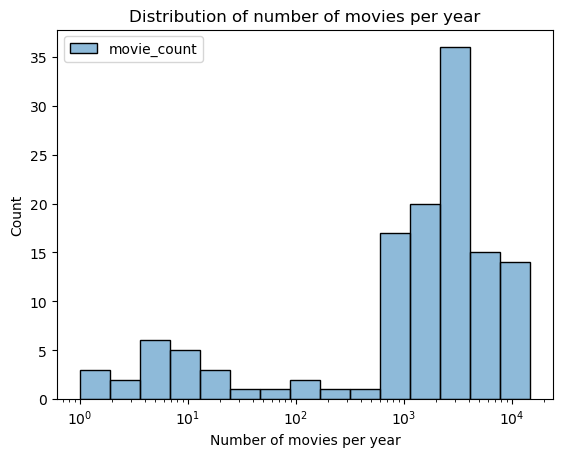

In [22]:
# first check the distribution of movies numbers in each year
characters_by_year = characters.copy()
characters_by_year['release_date'] = pd.to_datetime(characters_by_year['release_date']) # transform to datetime format
characters_by_year['release_year'] = characters_by_year['release_date'].dt.to_period('Y') # create year column
characters_by_year['release_year'] = characters_by_year['release_year'].astype(str)
year_movie_count = characters_by_year.groupby('release_year')['wiki_movie_id'].count().reset_index()
year_movie_count['movie_count'] = year_movie_count['wiki_movie_id']# rename column
year_movie_count = year_movie_count[['release_year','movie_count']] # only keep necessary columns
m = sns.histplot(year_movie_count, log_scale=True).set_title('Distribution of number of movies per year')
plt.xlabel('Number of movies per year')
plt.ylabel('Count')

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
From the histogram, we can see that there are a few years where only little movies were produced. By  filtering out certain years with extremely few movies (under 50 movies) avoid a skewed computation of female ratio.

Text(0, 0.5, 'Count')

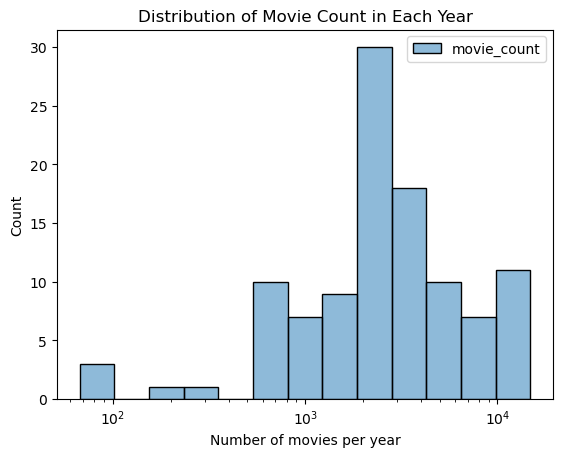

In [23]:
# filter out years with extremely few movies
year_movie_count = year_movie_count[year_movie_count['movie_count']>=50] # keep years with more than 50 movies
year_list= year_movie_count['release_year'] # create a list containing selected years
characters_by_year = characters_by_year[characters_by_year['release_year'].isin(year_list)]
m = sns.histplot(year_movie_count, log_scale=True).set_title('Distribution of Movie Count in Each Year')
plt.xlabel('Number of movies per year')
plt.ylabel('Count')

In [24]:
def gender_ratio(s, gender):
    count = len(s[s['actor_gender']==gender])
    
    return round((count/len(s)), 4)

    
female_ratio_by_year = characters_by_year.groupby('release_year').apply(lambda x: gender_ratio(x, 'F')).reset_index() # compute female ratio of each year
female_ratio_by_year['female_ratio'] = female_ratio_by_year[0] # rename column
female_ratio_by_year=female_ratio_by_year[['release_year','female_ratio']] # keep only necessary columns

male_ratio_by_year = characters_by_year.groupby('release_year').apply(lambda x: gender_ratio(x, 'M')).reset_index() # compute male ratio of each year
male_ratio_by_year['male_ratio'] = male_ratio_by_year[0] # rename column
male_ratio_by_year=male_ratio_by_year[['release_year','male_ratio']] # keep only necessary columns



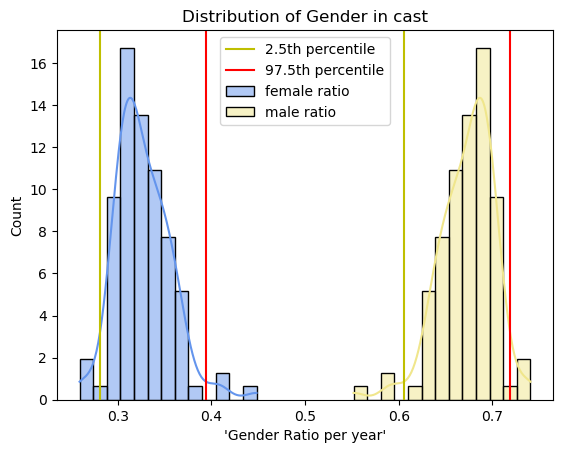

In [25]:
ax = sns.histplot(female_ratio_by_year.female_ratio.values, kde=True, stat='density', color = 'cornflowerblue', label='female ratio')
lower = np.percentile(female_ratio_by_year.female_ratio.values, 2.5)
upper = np.percentile(female_ratio_by_year.female_ratio.values, 97.5)
plt.axvline(x=lower, ymin=0, ymax=1,c='y')
plt.axvline(x=upper, ymin=0, ymax=1,c='r')

ax = sns.histplot(male_ratio_by_year.male_ratio.values, kde=True, stat='density', color = 'khaki',label='male ratio')
lower = np.percentile(male_ratio_by_year.male_ratio.values, 2.5)
upper = np.percentile(male_ratio_by_year.male_ratio.values, 97.5)
plt.axvline(x=lower, ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=upper, ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("'Gender Ratio per year'")
plt.ylabel("Count")
plt.title("Distribution of Gender in cast")
plt.legend()
plt.show()

At last, we got the final temporal flutuation of female ratio in cast from 1888 to 2016.

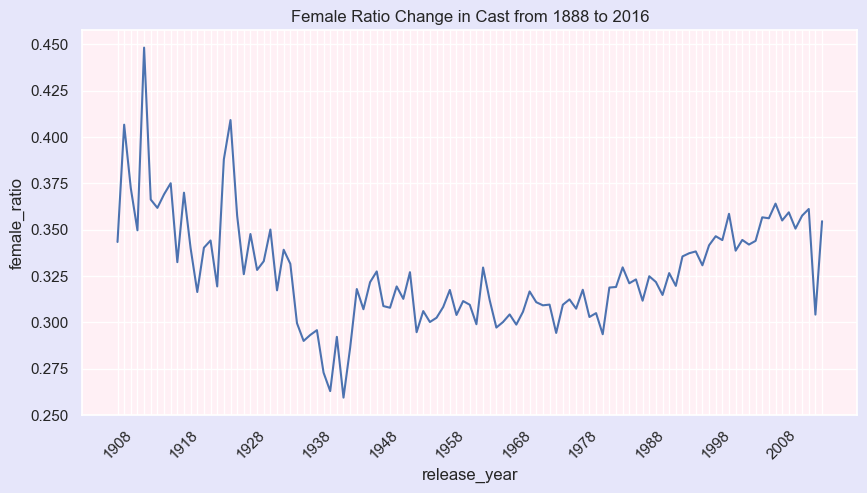

In [27]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set(rc={'axes.facecolor':'lavenderblush', 'figure.facecolor':'lavender'})
g = sns.lineplot(x='release_year',y='female_ratio',markers='o',data=female_ratio_by_year)
g.set_title('Female Ratio Change in Cast from 1888 to 2016')
g.tick_params(axis='x', rotation=45)
for ind, label in enumerate(g.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept 
        label.set_visible(True)
    else:
        label.set_visible(False)

### 2.1.2 Female ratio in directors

In [28]:
# load data
writers = pd.read_pickle('./data/writers.pickle')
directors = pd.read_pickle('./data/directors.pickle')

Let's first take a look at the overall female ratio in directors and writers!

In [29]:
female_ratio_directors = len(directors[directors['gender']=='F'])/len(directors)
female_ratio_writers = len(writers[writers['gender']=='F'])/len(writers)
print('The overall female ratio in directors and writers are {:.2f}'.format(female_ratio_directors),'and {:.2f}'.format(female_ratio_writers))

The overall female ratio in directors and writers are 0.15 and 0.21


The overall female ratios are much lower than expected! Then we would like to know how ratios change across this long period in directors and writers. Is it getting better for women directors and writers? Let's investigate into directors first!

In [30]:
# merge dataframe by title to get release year 
def ffemale_ratio(s):
    female_count = len(s[s['gender']=='F'])
    return round((female_count/len(s)), 4)
directors.rename(columns={'title': 'movie_name'}, inplace=True)# rename columns to get the key
directors_by_year = pd.merge(directors,movies, on = 'movie_name')
directors_by_year=directors_by_year[['movie_name','director_name','gender','release_date']] # keep only necessary columns
directors_by_year['release_date'] = pd.to_datetime(directors_by_year['release_date'])
directors_by_year['release_year'] = directors_by_year['release_date'].dt.to_period('Y') # create year column

In [31]:
# filter out years with extremely few movies 
directors_by_year['release_year'] = directors_by_year['release_year'].astype(str)
directors_by_year = directors_by_year[directors_by_year['release_year'].isin(year_list)]

Text(0.5, 1.0, 'Distribution of Female Ratio in Directors in Each Year')

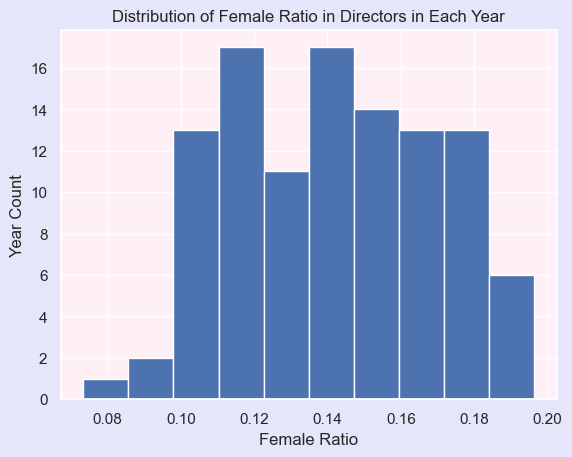

In [32]:
female_director_ratio_by_year = directors_by_year.groupby('release_year').apply(lambda x: ffemale_ratio(x)).reset_index()
female_director_ratio_by_year['female_ratio'] = female_director_ratio_by_year[0] # rename column
female_director_ratio_by_year=female_director_ratio_by_year[['release_year','female_ratio']] # keep only necessary columns
female_director_ratio_by_year.hist()
plt.xlabel('Female Ratio')
plt.ylabel('Year Count')
plt.title('Distribution of Female Ratio in Directors in Each Year')

The overall ratio is pretty low and not skewed, thus we don't use a logarithmic scale here. Now we got the final temporal flutuation of female ratio in directors from 1888 to 2016.

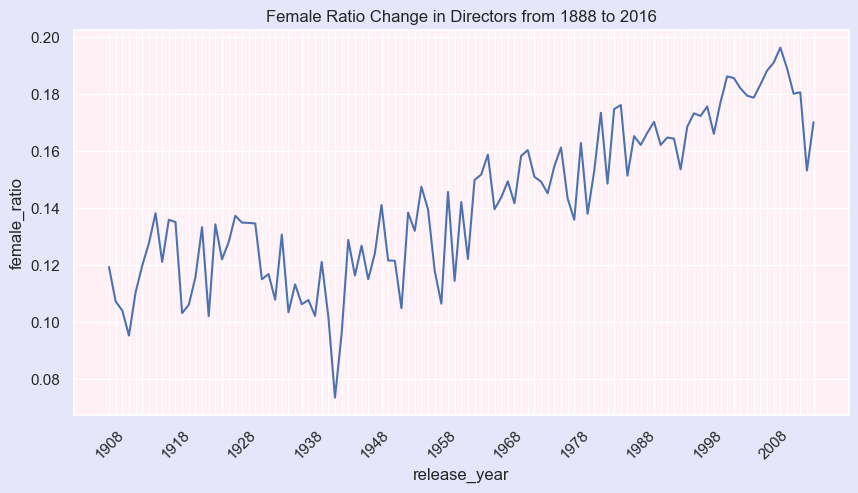

In [33]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set(rc={'axes.facecolor':'lavenderblush', 'figure.facecolor':'lavender'})
g = sns.lineplot(data=female_director_ratio_by_year,x='release_year',y='female_ratio',markers='o')
g.set_title('Female Ratio Change in Directors from 1888 to 2016')
g.tick_params(axis='x', rotation=45)
for ind, label in enumerate(g.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept 
        label.set_visible(True)
    else:
        label.set_visible(False)

### 2.1.3 Female ratio in writers
Let's repeat the same procedure and see what happens to writers!

In [34]:
writers.rename(columns={'title': 'movie_name'}, inplace=True)# rename columns to get the key
writers_by_year = pd.merge(writers,movies, on = 'movie_name')
writers_by_year=writers_by_year[['movie_name','writer_name','gender','release_date']] # keep only necessary columns
writers_by_year['release_date'] = pd.to_datetime(writers_by_year['release_date'])
writers_by_year['release_year'] = writers_by_year['release_date'].dt.to_period('Y') # create year column

In [35]:
# filter out years with extremely few movies 
writers_by_year['release_year'] = writers_by_year['release_year'].astype(str)
writers_by_year = writers_by_year[writers_by_year['release_year'].isin(year_list)]

Text(0.5, 1.0, 'Distribution of Female Ratio in Writers in Each Year')

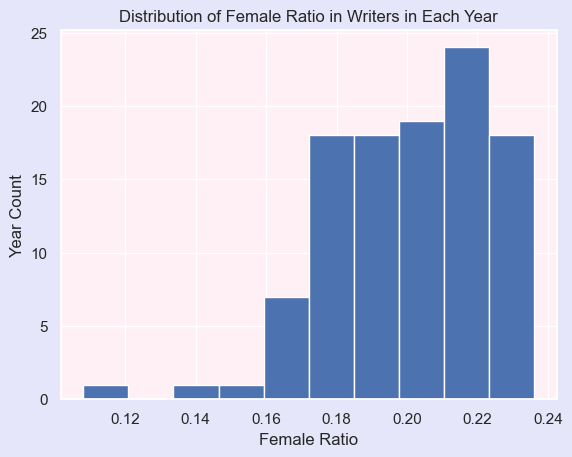

In [36]:
female_writer_ratio_by_year = writers_by_year.groupby('release_year').apply(lambda x: ffemale_ratio(x)).reset_index()
female_writer_ratio_by_year['female_ratio'] = female_writer_ratio_by_year[0] # rename column
female_writer_ratio_by_year=female_writer_ratio_by_year[['release_year','female_ratio']] # keep only necessary columns
female_writer_ratio_by_year.hist()
plt.xlabel('Female Ratio')
plt.ylabel('Year Count')
plt.title('Distribution of Female Ratio in Writers in Each Year')

Similarly,  we got the final temporal flutuation of female ratio in writers from 1888 to 2016.

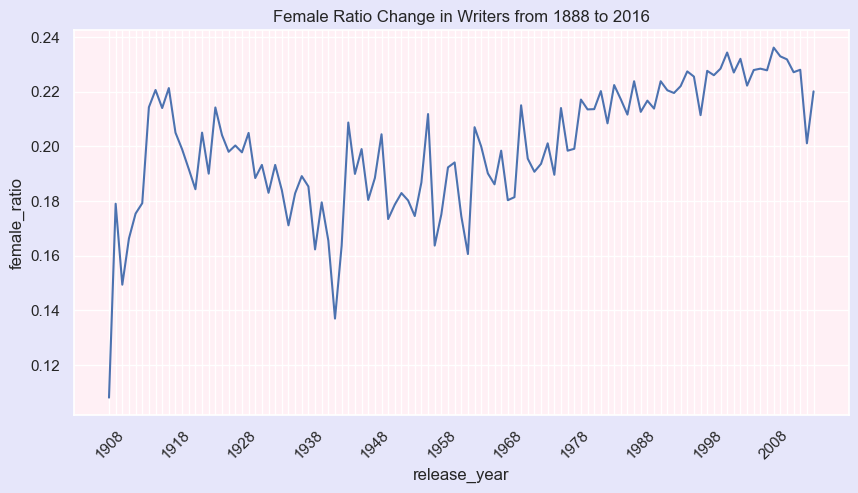

In [37]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set(rc={'axes.facecolor':'lavenderblush', 'figure.facecolor':'lavender'})
g = sns.lineplot(data=female_writer_ratio_by_year ,x='release_year',y='female_ratio',markers='o')
g.set_title('Female Ratio Change in Writers from 1888 to 2016')
g.tick_params(axis='x', rotation=45)
for ind, label in enumerate(g.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept 
        label.set_visible(True)
    else:
        label.set_visible(False)

Although the female ratio in directors and writers gradually increases during a century, the female proportion is somehow still unsatisfactory, as it accounts for less than a quarter. Men are dominant in movie production, which is even worse than what happens in cast.
Meanwhile, we also noticed that around 1938, all the female ratio in cast, directors and writers experienced dramatic decline. It's possibly due to second world war when women tend to have less chance in their movie career in wartime, compared to peacetime.

###  2.2 Age gap between males and females in cast

In [38]:
age = characters.copy()
age = age[age['actor_age_at_release']>0]# keep only positive values

Text(0.5, 1.0, 'Age Distribution of Actresses and Actors at Release')

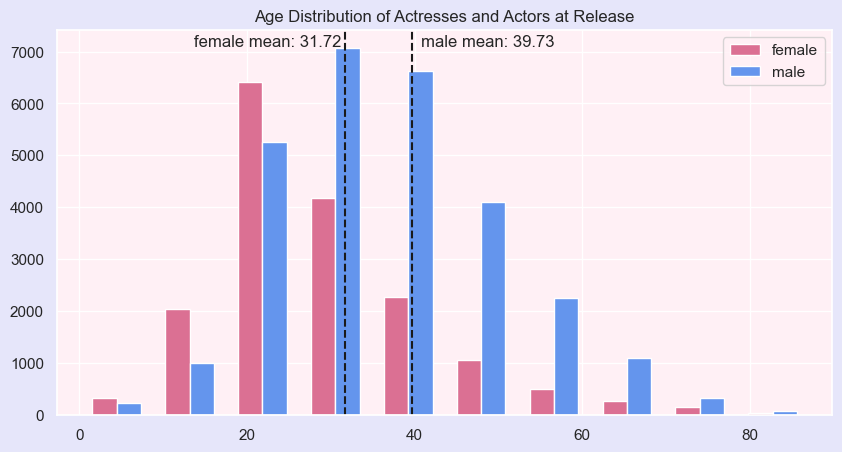

In [39]:
# age gap between actresses and actors
female_chara = age[age['actor_gender']=='F'].dropna()
male_chara = age[age['actor_gender']=='M'].dropna()
np.random.seed(0)
fig, ax = plt.subplots(figsize=(10, 5))
a_heights, a_bins = np.histogram(female_chara['actor_age_at_release'])
b_heights, b_bins = np.histogram(male_chara['actor_age_at_release'], bins=a_bins)
width = (a_bins[1] - a_bins[0])/3
ax.bar(a_bins[:-1], a_heights, width=width, facecolor='palevioletred',label='female')
ax.axvline(female_chara['actor_age_at_release'].mean(), color='k', linestyle='dashed', linewidth=1.5)
ax.text(female_chara['actor_age_at_release'].mean()-18,7100,'female mean: {:.2f}'.format(female_chara['actor_age_at_release'].mean()))

ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='cornflowerblue',label='male')
ax.axvline(male_chara['actor_age_at_release'].mean(), color='k', linestyle='dashed', linewidth=1.5)
ax.text(male_chara['actor_age_at_release'].mean()+1,7100,'male mean: {:.2f}'.format(male_chara['actor_age_at_release'].mean()))
ax.legend()
ax.set_title('Age Distribution of Actresses and Actors at Release')

From the age distribution plot, we can see that the averge age of actors is around 40 years old, which is 8 years elder than actresses( a huge gap! ) . Also, age distribution of actors is closer to normal distribution, while actresses declines dramatically once they are no longer at their 'best age'. Women tend to have shorter career in acting. It's also noteworthy that for actors at the same age, men are dominant after 30 years old. It implies that good looks may be more valued for actresses than actors in movie industry.

###  2.3 Gender difference in different domains
#### 2.3.1 Genre

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
In order to see if there is a difference between genders regarding genres the top 30 female and male genres is computed. Those correspond to the movies where the respective female or male ration is the highest.
Only the genres with more than 100 movies were taken into consideration. <br><br>
    
Instead of checking which genre has the highest female / male ration it is also interesting to order the 30 most appearing genres according to the gender ratio. 

In [41]:
def get_gender_ratio(s, gender):
    ''' 
    Calculates the ratio gender
    Arg:
        s: Object containing all male or female actor in a genre. (M or F)
        gender: the gender for which the ratio should be computed for
    '''
    
    gender_count = 0
    for i in range(len(s)):
        if s[i] == gender:
            gender_count = gender_count+1
    return round(gender_count/len(s), 4)


In [593]:
def genderratio_domain(df, domain, threshold,characters, gender):
    ''' 
    
    Arg:
        df = movie_genres
        domain = domain
        threshold = number of movies has to be higher than threshhold for domain specific value to be counted as general
        characters = characters df
        gender = 'F' or 'M'
    '''
    if gender == 'F':
        gender_ratio = "female_ratio"
    else:
        gender_ratio = "male_ratio"  
    
    # generate dataframe containing the actors gender and domain-specific value of the movie
    domain_ct = df[domain].value_counts()

    # consider a domain is general when at least threshold-number of movies in it
    general_genres = domain_ct[domain_ct > threshold]
    general_genres = general_genres.index.tolist()
    character_domain = pd.merge(left = characters, right = df, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')
    
    # merge losses some data, it's possible that in some years no character is matching
    if len(character_domain)>0:
        # Extract genres that has actor/ actress
        # Sum the number of male / female actor per genre and calculate female ratio
        gender_genres = character_domain[character_domain[domain].isin(general_genres)][['actor_gender', domain]].groupby(domain).agg('sum')
        # checking for general genre can lead to loss of some data
        if len(gender_genres)>0:
            gender_genres[gender_ratio] = gender_genres['actor_gender'].apply(lambda x: get_gender_ratio(x,gender))
            gender_genres = gender_genres.drop(columns=['actor_gender'])
            gender_genres = gender_genres.sort_values(by=gender_ratio, ascending=False).iloc[:30]
    else:
        gender_genres = []
    
    return gender_genres

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Parallel to the comparison of casts, only the years are considered where at least 50 movies have been produced. Through the merge with characters to obtain the gender of the cast, entries get lost. Therefore another threshold of 50 is set. 
    


In [92]:
# get top 30 genres of all movie
top30_genres = movie_genres['genres'].value_counts()[:30].to_frame().reset_index().rename(columns={"index": "genres", "genres": "counts"})
top30_genres.head()

,genres,counts
0,Drama,34007
1,Comedy,16349
2,Romance Film,10234
3,Black-and-white,9094
4,Action,8798


In [98]:
character_genres = pd.merge(left = characters, right = movie_genres, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')

genre_gender = character_genres[character_genres.genres.isin(top30_genres.genres.to_list())][['actor_gender', 'genres']].groupby('genres').agg('sum')
genre_gender['female_ratio'] = genre_gender['actor_gender'].apply(lambda x: get_gender_ratio(x, "F"))
genre_gender = genre_gender.drop(columns=['actor_gender']).reset_index()
genre_gender = pd.merge(left = genre_gender, right = top30_genres, on='genres', how='left')
genre_gender = genre_gender.sort_values(by='counts', ascending=False).reset_index()

[Text(0.5, 1.0, 'Female cast ratio in top 30 genres')]

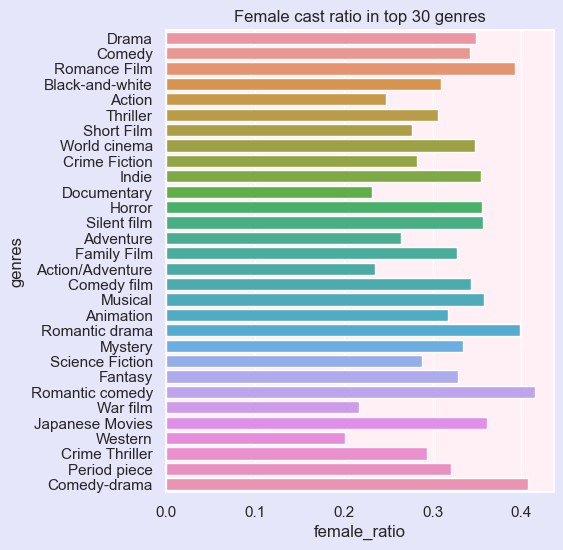

In [102]:
f, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=genre_gender, x="female_ratio", y="genres").set(title='Female cast ratio in top 30 genres')

##### For top 30 genres, only romantic comedy, comedy drama, romantic drama and romance film have female cast ratio around 0.4. It seems that female is more likely to associated with genres related to romance. We are interested to see what genres has the highest female cast ratio.

[Text(0.5, 1.0, 'Top 30 Female Genres')]

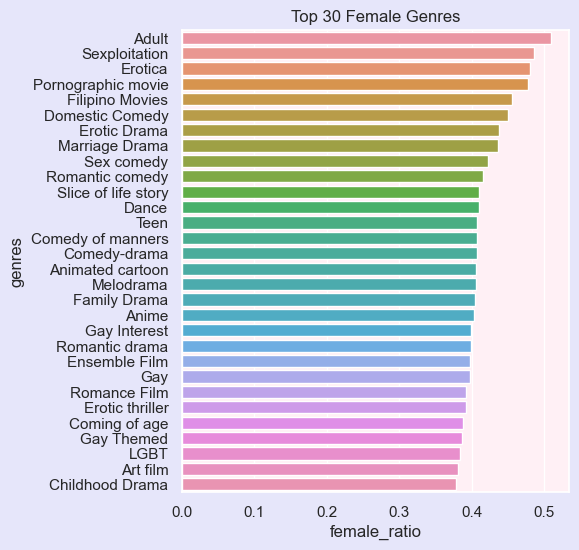

In [43]:
female_genres = genderratio_domain(movie_genres, 'genres', 100, characters, 'F')
female_genres['genres'] = female_genres.index
f, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=female_genres, x="female_ratio", y="genres").set(title='Top 30 Female Genres')

##### The result of highest female cast ratio is very interesting. Most of the genres are related to erotic content. Even with this case, most female cast ratio are still below 0.5.

[Text(0.5, 1.0, 'Top 30 Male Genres')]

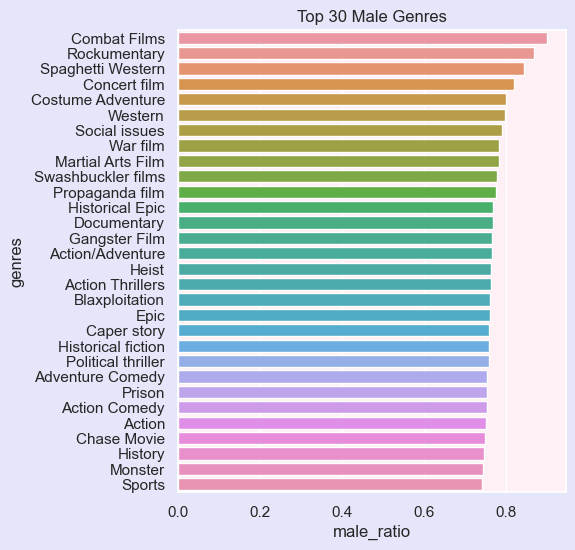

In [44]:
male_genres = genderratio_domain(movie_genres, 'genres', 100, characters, 'M')
male_genres['genres'] = male_genres.index
f, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=male_genres, x="male_ratio", y="genres").set(title='Top 30 Male Genres')

##### For highest male cast ratio, the genres are more serious in terms of the genreal expression. Genres have more variety from action, advanture to social issues and history. 

#### 2.3.1 Countries

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Another task is to show the gender gap across the world. For that we show the countries that produces movies with the highes female or male ratio. In this case all countries are considered that have produced more than 50 movies.

[Text(0.5, 1.0, 'Top 30 Female Countries')]

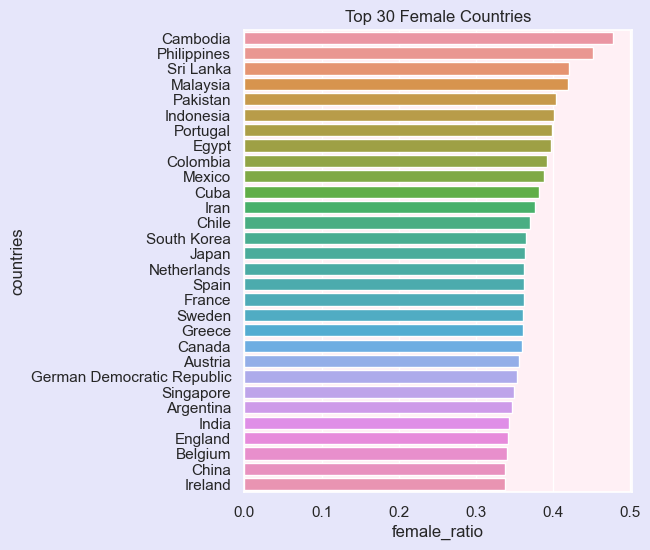

In [46]:
female_countries = genderratio_domain(movie_countries, 'countries', 50, characters, 'F')
female_countries['countries'] = female_countries.index
f, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=female_countries, x="female_ratio", y= 'countries').set(title='Top 30 Female Countries')

[Text(0.5, 1.0, 'Top 30 Male Countries')]

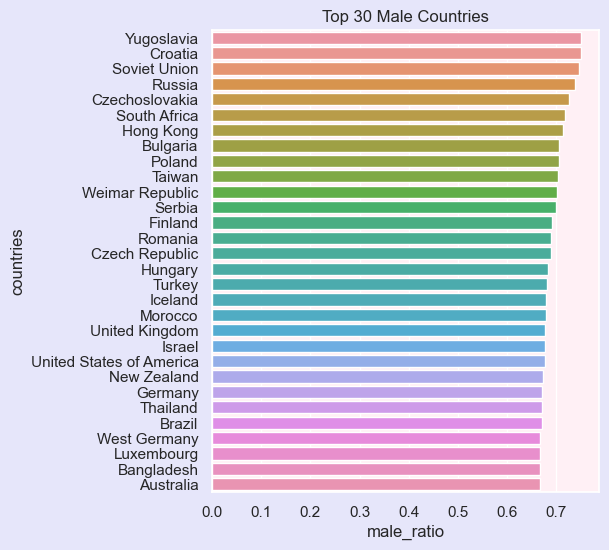

In [47]:
male_countries = genderratio_domain(movie_countries, 'countries', 50, characters, 'M')
male_countries['countries'] = male_countries.index
f, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=male_countries, x="male_ratio", y= 'countries').set(title='Top 30 Male Countries')

#### 2.3.1 Language

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
In order to see if countries with the same language have a similar gendergap the corresponding figure was created for female and male ratios.

[Text(0.5, 1.0, 'Top 30 Female lanugages')]

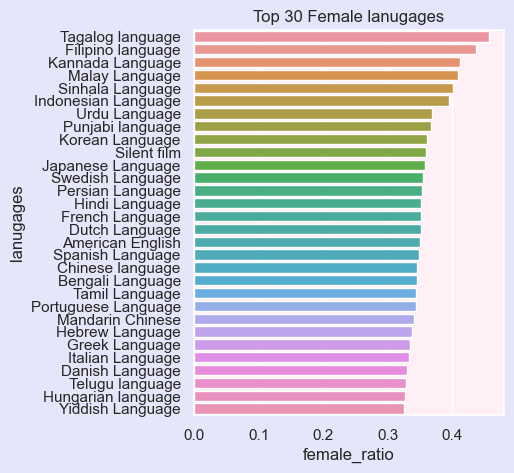

In [594]:
female_language = genderratio_domain(movie_languages, 'languages', 50, characters, 'F')
female_language['lanugages'] = female_language.index
f, ax = plt.subplots(figsize=(4, 5))
sns.barplot(data=female_language, x="female_ratio", y= 'lanugages').set(title='Top 30 Female lanugages')

[Text(0.5, 1.0, 'Top 30 male lanugages')]

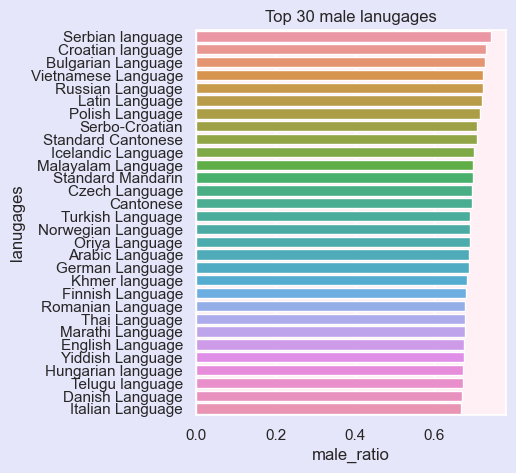

In [595]:
male_language = genderratio_domain(movie_languages, 'languages', 50, characters, 'M')
male_language['lanugages'] = male_language.index
f, ax = plt.subplots(figsize=(4, 5))
sns.barplot(data=male_language, x="male_ratio", y= 'lanugages').set(title='Top 30 male lanugages')

## Change over time

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
For the next task the change regarding time should be shown. The genres popular at a certain time varies quite a bit, therefore no fixed set was analyzed but always the 30 most popular genres at a time. Since in the begining only a few movies were produced, a genre is taken into account if 50 such movies were generated. After the df containing the gender ratio per year and per genre is generated, only those genres are kept that have a value in at least 50% of the entries. Todo: Think what threshold is most representing. <br>
A suitable plot representing the change over time has to be found, where NaN values are appropriatly handled.

#### Genre

In [598]:
movie_genres['release_date'] = pd.to_datetime(movie_genres['release_date']) # transform to datetime format
movie_genres['release_year'] = movie_genres['release_date'].dt.to_period('Y')
movie_genres.drop(columns = 'release_date')
years = movie_genres['release_year'].drop_duplicates( keep='last')

In [599]:
female_genres_timeseries = pd.DataFrame()
for iter_year in range(len(years)): 
    genre_year = movie_genres[movie_genres['release_year']==years.iloc[iter_year]]
    subdata = genderratio_domain(genre_year, 'genres', 50, characters, 'F')
    if len(subdata)>0:
        newname = years.iloc[iter_year]
        subdata = subdata.rename(columns={'female_ratio': newname})
        female_genres_timeseries = pd.concat([female_genres_timeseries, subdata], axis=1)
        female_genres_timeseries        

In [600]:
female_genres_timeseries_clean = female_genres_timeseries.copy(deep=True)
to_drop = []
for iter_genre in range(20):
    subdata = female_genres_timeseries.iloc[iter_genre,:]
    nan_perc = subdata.isna().sum()/ (female_genres_timeseries.shape[1])
    if nan_perc > 0.8:
        to_drop.append(female_genres_timeseries.index[iter_genre])

<function matplotlib.pyplot.legend(*args, **kwargs)>

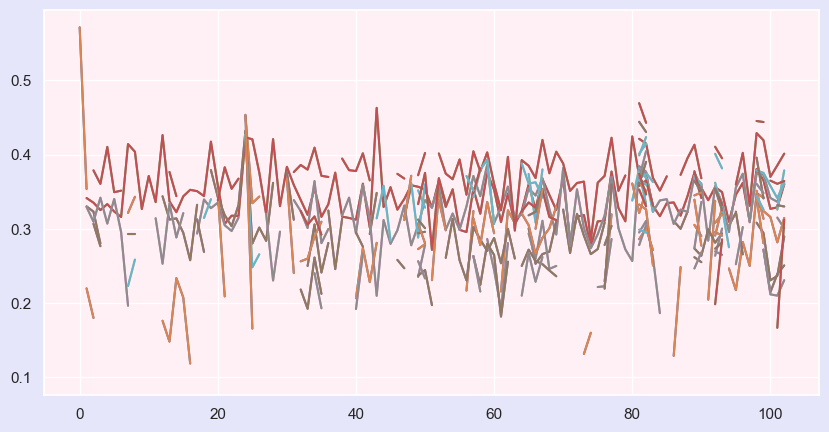

In [601]:
f, ax = plt.subplots(figsize=(10, 5))

for iter_genre in range (female_genres_timeseries_clean.shape[0]):
    plt.plot(female_genres_timeseries_clean.iloc[iter_genre,:].values)
    plt.plot(female_genres_timeseries_clean.iloc[iter_genre,:].values)
plt.legend

## Task 3 Extract verbs and adjectives of the plot's summaries

In [58]:
# Load spacy pipeline
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities") # Merge entities like ['David' 'Bowie'] to ['David Bowie']

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [59]:
def tag_adj(text):
    """
    Find all noon/adjective pair in the given text
    :param text: Text composed of one or multiple sentences
    :return: list of noon/adjective pair
    """
    doc = nlp(text)
    noun_adj_pairs = []
    for token in doc:
        ## Is the word a proper noun / noun / pronoun
        if token.pos_ in ('PROPN', 'NOUN', 'PRON'):
            for child in token.children:
                ## Is the child an adjectival modifier
                if child.dep_ == 'amod':
                    noun_adj_pairs.append((token.lemma_, child.lemma_))
    return noun_adj_pairs

In [60]:
## Example
print(tag_adj("There is a red card in the blue envelope and a beautiful girl."))
print(tag_adj("She is beautiful."))

[('card', 'red'), ('envelope', 'blue'), ('girl', 'beautiful')]
[]


In [61]:
def tag_verb(text):
    """
    Find all noon/verb pair in the given text
    :param text: Text composed of one or multiple sentences
    :return: list of noon/verb pair
    """
    doc = nlp(text)
    verbs = []
    for possible_verb in doc:
        if possible_verb.pos_ == 'VERB':
            for possible_subject in possible_verb.children:
                if possible_subject.dep_ == 'nsubj':
                    verbs.append((possible_subject.lemma_, possible_verb.lemma_))
                    break
    return verbs

We extract the adjectives and verbs of each plot

In [ ]:
plots['verb'] = plots['plot'].apply(tag_verb) # long computation

In [ ]:
plots['adj'] = plots['plot'].apply(tag_adj) # long computation

In [ ]:
# Save intermediate result since computation is quite long
plots[['wiki_movie_id', 'verb', 'adj']].to_pickle('data/plots.pickle')

In [60]:
# Load saved result
plots[['wiki_movie_id', 'verb','adj']] = pd.read_pickle('data/plots.pickle')
plots.head()

,wiki_movie_id,plot,verb,adj
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[(Shlykov, develop)]","[(driver, work), (relationship, bizarre)]"
1,31186339,The nation of Panem consists of a wealthy Capi...,"[(nation, consist), (district, provide), (trib...","[(Capitol, wealthy), (district, poor), (rebell..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[(who, give), (who, achieve), (Induchoodan, lo...","[(son, only), (judge, idealist), (rank, top), ..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[(the Lemon Drop Kid, tout), (Kid, come), (Kid...","[(hustle, several), (hustle, successful), (wom..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[(baby, sleep), (family, enjoy), (lindy, retur...","[(daughter, nine-week-old), (camper, fellow), ..."


In [61]:
# Dict that match all characters to their gender
matcher = pd.Series(characters.actor_gender.values, index=characters.character_name).to_dict()
matcher.update({'he' : 'M', 'she' : 'F'})

In [62]:
# We build a dataframe that groups the subject and the verb of every plot
gender_verb = pd.DataFrame(plots.verb.explode().to_list(), columns=['noon', 'verb'])
# We create a new column that assignee to subject to male or female based on the matcher
gender_verb['gender'] = gender_verb.noon.apply(matcher.get)
gender_verb.dropna(inplace=True)
gender_verb.head()

,noon,verb,gender
5,she,starve,F
6,he,warn,M
10,she,discover,F
12,he,say,M
20,she,recover,F


In [63]:
# We do the same for adjectives
gender_adj = pd.DataFrame(plots.adj.explode().to_list(), columns=['noon', 'adj'])
gender_adj['gender'] = gender_adj.noon.apply(matcher.get) ## TODO is this matcher adequate ???
gender_adj.dropna(inplace=True)
gender_adj.head()

,noon,adj,gender
12,Haymitch Abernathy,past,M
19,Rue,die,F
53,woman,beautiful,F
56,Moran,furious,F
61,Santa Claus,cornerside,M


In [64]:
gender_verb.loc[gender_verb.gender == 'F'].verb.value_counts().head(10)

have     5166
tell     4209
go       4154
find     3873
leave    2887
get      2492
take     2473
try      2407
meet     2382
see      2373
Name: verb, dtype: int64

In [65]:
gender_verb.loc[gender_verb.gender == 'M'].verb.value_counts().head(10)

have     10558
go        8293
find      8261
tell      7102
take      6112
get       5853
try       5852
meet      5156
see       4865
leave     4705
Name: verb, dtype: int64

In [66]:
gender_adj.loc[gender_adj.gender == 'F'].adj.value_counts().head(10)

young         2256
beautiful      637
old            565
other          310
mysterious     180
elderly        159
pregnant       158
new            158
attractive     155
real           129
Name: adj, dtype: int64

In [67]:
gender_adj.loc[gender_adj.gender == 'M'].adj.value_counts().head(10)

young      469
real       258
local      195
new        181
old        170
former     163
little     127
corrupt    111
angry      103
first      100
Name: adj, dtype: int64

### 3.2  Sentiment Analysis and  Word Frequency 

The types from tvtropes are not sufficient for sentiment analysis, since the dictionary is not large enough. Thus, we looked into current sentiment libraries to see if there is any finding. Here we tried nltk.

In [68]:
nltk_analyzer = SentimentIntensityAnalyzer()
gender_adj['nltk']=gender_adj['adj'].apply(lambda x: nltk_analyzer.polarity_scores(x)['compound'])
gender_adj.nltk.value_counts()

 0.0000    19122
 0.5994      660
 0.4404      345
-0.4019      309
-0.5106      300
           ...  
-0.6705        6
 0.1027        4
 0.6486        3
 0.0258        1
-0.6808        1
Name: nltk, Length: 71, dtype: int64

In [69]:
# compute positive and negative ratio 
def posneg_ratio(df):
    neg=df[df['nltk']<0].count()[0]
    pos=df[df['nltk']>0].count()[0]
    num= neg+ pos
    negrt=neg/num
    posrt=pos/num
    return (negrt, posrt)

In [70]:
male_neg_pos = posneg_ratio(gender_adj[gender_adj['gender']=='M'])
female_neg_pos = posneg_ratio(gender_adj[gender_adj['gender']=='F'])
print ('The negative and positive ratio for male is {:.2f}'.format(male_neg_pos[0]),'and{:.2f}'.format(male_neg_pos[1]))
print ('The negative and positive ratio for female is {:.2f}'.format(female_neg_pos[0]),'and{:.2f}'.format(female_neg_pos[1]))

The negative and positive ratio for male is 0.66 and0.34
The negative and positive ratio for female is 0.48 and0.52


We filtered out these neutral words and use the adjectives left that show polarity to compute the negative and postive ratio of description in movie plots for men and women. It turns out men are much more negatively described. But is it actually the case? we are not able to conclude for now, because the number of neutral words are much more than expected. Among 27177 adjectives, 19122 were labelled as neutral by NLTK. So we tried to see if we could get any insight from word frequency instead.

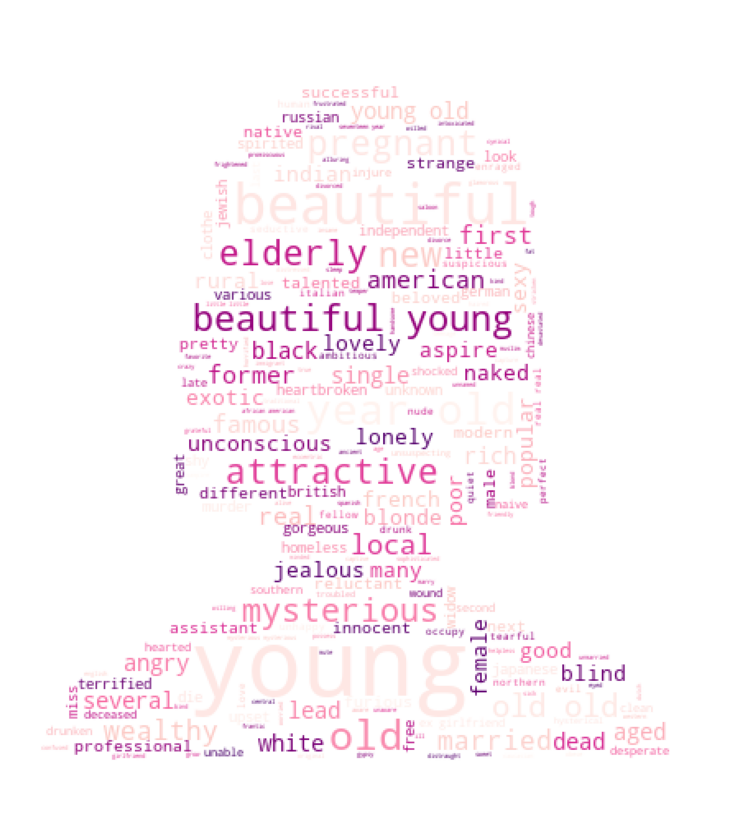

In [71]:
female = gender_adj[gender_adj['gender']=='F']
mask_fem = np.array(Image.open("fem_mask.png"))
wordcloud = WordCloud(background_color="White",colormap ='RdPu',mask = mask_fem,random_state=42).generate(' '.join(female['adj']))
image_colors = ImageColorGenerator(mask_fem)
plt.figure(facecolor='w',figsize=(14,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

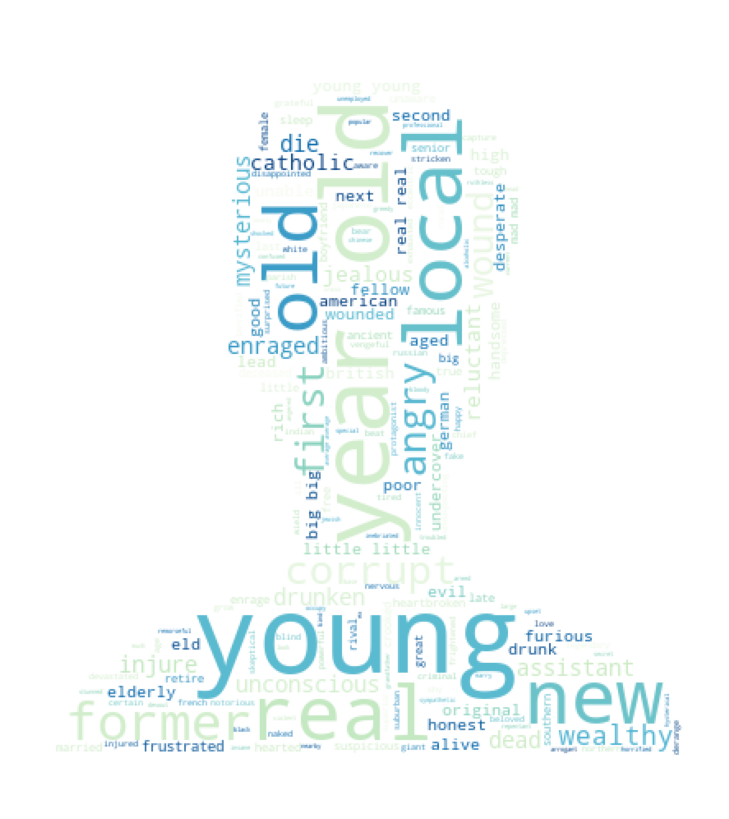

In [72]:
male = gender_adj[gender_adj['gender']=='M']
mask_mal = np.array(Image.open("mal_mask.png"))
wordcloud = WordCloud(background_color="white",mask = mask_mal,random_state=42,colormap='GnBu').generate(' '.join(male['adj']))
plt.figure(facecolor='w',figsize=(14,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()